In [6]:
# ruff: noqa: E402
%run _common.ipynb
%matplotlib inline

import torch
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

from node_homotopy.dynamics import LotkaVolterra
from node_homotopy.odesolve import odesolve
from node_homotopy.smoothing import CubicSplineSmoothing
from node_homotopy.synchronization import CouplingTerm, SynchronizedDynamics

## Effect of coupling strength on the synchronized dynamics

In [2]:
lotka_drive = LotkaVolterra(a=1.3)
lotka_perturbed = LotkaVolterra(a=1.3 * 0.5)

u0 = torch.tensor([0.44249296, 4.6280594]).view(1, -1)
t = torch.arange(0, 15, 0.1)

with torch.no_grad():
    u_drive = odesolve(lotka_drive, u0, t)

    u_responses = []
    coupling_strengths = (0.0, 0.1, 1.0)
    u_drive_interp = CubicSplineSmoothing(t, u_drive)
    for k in tqdm(coupling_strengths):
        coupling = CouplingTerm(u_drive_interp, k)
        lotka_sync = SynchronizedDynamics(lotka_perturbed, coupling)
        u_responses.append(odesolve(lotka_sync, u0, t))

100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Note that with increasing values of the coupling strength, the response trajectory approches the drive trajectory more and more.

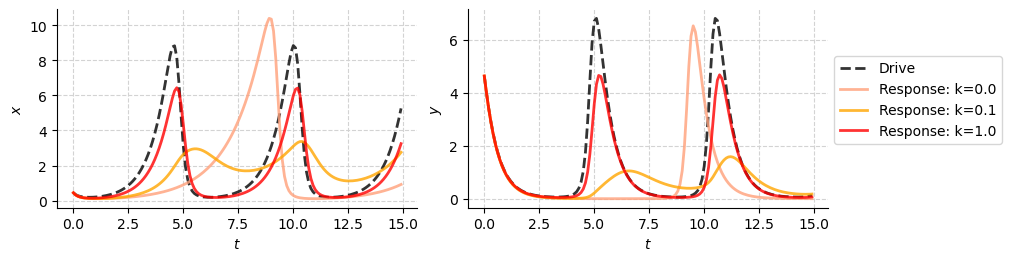

In [9]:
colors = ("lightsalmon", "orange", "red")
with mpl.rc_context({"lines.linewidth": 2}):
    fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))
    for i, (ax, ylabel) in enumerate(zip(axes, ("$x$", "$y$"))):
        ax.plot(
            t,
            u_drive[0, i],
            "--",
            color="black",
            alpha=0.8,
            label="Drive",
        )
        for k, u_resp, c in zip(coupling_strengths, u_responses, colors):
            ax.plot(t, u_resp[0, i], color=c, alpha=0.8, label=f"Response: k={k}")
        ax.set_ylabel(ylabel)
        ax.set_xlabel("$t$")
    axes[-1].legend(loc="upper right", bbox_to_anchor=(1.5, 0.8))